# 09_Q_scores

Use Q scores to see how well the original embedding fits the hyperbolic plane

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')
import os
workdir = '../results/09'
os.makedirs(workdir, exist_ok=True)


In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import torch 
from refs import celltype_colors
import matplotlib.pyplot as plt
from IPython.display import Image
from run_poincare_map import features_names

from main import *
from poincare_maps import *
from embedding_quality_score import get_quality_metrics


In [3]:
rna_pca_name = '../results/03/rna_pca.celltype_label'
rna_simba_name = '../results/03/rna_simba.celltype_label'
atac_pca_name = '../results/03/atac_std_pca.celltype_label'
atac_simba_name = '../results/03/atac_simba.celltype_label'
simba_multi_name = '../results/03/multi_simba.celltype_label'

names = [rna_pca_name, rna_simba_name, atac_pca_name, atac_simba_name, simba_multi_name]

poincare_results = {
    "RNA PCA": rna_pca_name, "RNA Simba": rna_simba_name, 
    "ATAC PCA (standard)": atac_pca_name, "ATAC Simba": atac_simba_name, 
    "Simba Multi": simba_multi_name
}

In [4]:
dist_from_origins_fn = "../results/05/dist_from_origins.csv"
dist_from_origins_df = pd.read_csv(dist_from_origins_fn, sep=',')

In [6]:
dist_from_origins_df

,x,y,labels,dist_from_origin,dist_from_TAC-1,name
0,-0.041638,-0.006655,TAC-1,0.084382,0.059359,RNA PCA
1,-0.107620,0.002094,TAC-1,0.216119,0.176808,RNA PCA
2,0.031848,-0.027072,TAC-1,0.083649,0.117622,RNA PCA
3,-0.092457,0.012742,TAC-1,0.187207,0.160049,RNA PCA
4,-0.052169,-0.081695,TAC-1,0.194473,0.111875,RNA PCA
...,...,...,...,...,...,...
31962,-0.030961,0.019797,TAC-2,0.073532,0.420982,Simba Multi
31963,0.116407,0.215752,TAC-1,0.500497,0.245015,Simba Multi
31964,0.302629,-0.128221,TAC-2,0.682676,0.586310,Simba Multi
31965,0.055994,0.193045,TAC-1,0.407551,0.277414,Simba Multi


In [15]:
q_scores_df = pd.DataFrame(index=list(features_names.keys()), columns=['Method', 'Qlocal', 'Qglobal', 'Kmax'])
for name, poincare_coor_df in dist_from_origins_df.groupby('name'):
    features_df = pd.read_csv(f"{features_names[name]}.csv", sep=',').drop(columns='labels')
    
    df = pd.DataFrame(columns=['Dataset', 'Method', 'Qlocal', 'Qglobal', 'Kmax'])
    Qlocal, Qglobal, Kmax = get_quality_metrics(
            features_df.values, 
            poincare_coor_df[['x', 'y']].values, 
            distance='poincare', 
            fname=None,
            verbose=True)
    q_scores_df.loc[name, 'Method'] = 'Poincare'
    q_scores_df.loc[name, 'Qlocal'] = Qlocal
    q_scores_df.loc[name, 'Qglobal'] = Qglobal
    q_scores_df.loc[name, 'Kmax'] = Kmax

Qlocal = 0.26, Qglobal = 0.70, Kmax = 921
Qlocal = 0.35, Qglobal = 0.73, Kmax = 714
Qlocal = 0.33, Qglobal = 0.74, Kmax = 765
Qlocal = 0.33, Qglobal = 0.74, Kmax = 856
Qlocal = 0.41, Qglobal = 0.78, Kmax = 861


In [33]:
data_types = pd.Series({
    "RNA PCA": "RNA", 
    "RNA Simba": "RNA", 
    "ATAC PCA (standard)": "ATAC", 
    "ATAC Simba": "ATAC", 
    "Simba Multi": "RNA+ATAC"
})
embed_method_types = pd.Series({
    "RNA PCA": "PCA", 
    "RNA Simba": "SIMBA", 
    "ATAC PCA (standard)": "PCA", 
    "ATAC Simba": "SIMBA", 
    "Simba Multi": "SIMBA"
})
q_scores_df.loc[data_types.index, 'Data Type'] = data_types.copy()
q_scores_df.loc[embed_method_types.index, 'Embedding Method Type'] = embed_method_types.copy()

In [17]:
q_scores_fn = f'{workdir}/q_scores.csv'
print(q_scores_fn)
q_scores_df.to_csv(q_scores_fn)

../results/09/q_scores.csv


In [34]:
q_scores_df

,Method,Qlocal,Qglobal,Kmax,Data Type,Embedding Method Type
RNA PCA,Poincare,0.32934,0.737088,765,RNA,PCA
RNA Simba,Poincare,0.326661,0.735021,856,RNA,SIMBA
ATAC PCA,NaN,NaN,NaN,NaN,ATAC,NaN
ATAC PCA (standard),Poincare,0.264946,0.703255,921,ATAC,PCA
ATAC Simba,Poincare,0.351464,0.730622,714,ATAC,SIMBA
Simba Multi,Poincare,0.410784,0.78212,861,RNA+ATAC,SIMBA


<Axes: xlabel='Qlocal', ylabel='Qglobal'>

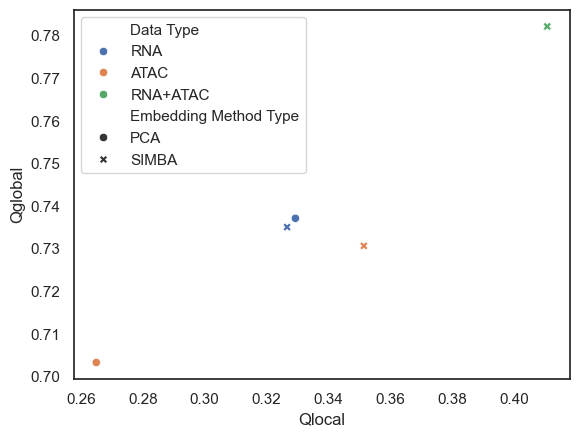

In [36]:
sns.scatterplot(q_scores_df.dropna(), x='Qlocal', y='Qglobal', hue='Data Type', style='Embedding Method Type')
# for name, r in q_scores_df.dropna().iterrows():
#     plt.annotate(name, (r['Qlocal'], r['Qglobal']))